<a href="https://colab.research.google.com/github/parshwa1999/Map-Segmentation/blob/master/Building_of_MapSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/MapSegClean/"
%cd gdrive/My\ Drive/MapSegClean/


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content/gdrive/My Drive/MapSegClean


In [0]:
import cv2
import numpy as np
import h5py
#import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [0]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

from skimage import color

In [0]:
h5f = h5py.File('BuildingLabels.h5','r')
roadlabel = h5f['BuildingLabels'][:]
h5f.close()

h5f = h5py.File('BuildingImages.h5','r')
road = h5f['BuildingImages'][:]
h5f.close()

In [0]:
#for i in range(road.shape[0]):
#  cv2.imwrite("Road/" + str(i) + ".png", road[i])

#for i in range(roadlabel.shape[0]):
#  cv2.imwrite("RoadLabel/" + str(i) + ".png", roadlabel[i])


In [0]:
"""Loss Fuction"""
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


In [7]:
print(roadlabel.shape)

roadlabelgray = []

for i in range(roadlabel.shape[0]):
  roadlabelgray.append(cv2.cvtColor(roadlabel[i], cv2.COLOR_BGR2GRAY))

roadlabelgray = np.asarray(roadlabelgray)
#del 

roadlabel = np.expand_dims(roadlabelgray, -1)
print(roadlabel.shape)

(24520, 256, 256, 3)
(24520, 256, 256, 1)


In [0]:
seed = 56
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3
#del train_images, train_masks
#del test_images, test_masks

In [9]:
"""
Model
"""

inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0         

In [0]:
"""
Hyperparameters
"""
#print(roadlabel.shape)
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 32


In [11]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://fb062fa8.ngrok.io


In [0]:
model_path = "Models/Final_unet_building_weights.h5"

In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from datetime import datetime

checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [0]:
earlystopper = EarlyStopping(monitor = 'val_loss', 
                             min_delta = 0, 
                             patience = 7,
                             mode='auto',
                            restore_best_weights = True)

In [15]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [16]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])   

In [17]:
history = model.fit(road,
                    roadlabel.astype(np.float16)/255,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )

with open("History/Building_History.pickle", 'wb') as f:
    pickle.dump(history, f)



Train on 22068 samples, validate on 2452 samples


Epoch 1/100
22068/22068 [==============================] - 183s 8ms/step - loss: 0.5140 - iou_coef: 0.2668 - val_loss: 0.4257 - val_iou_coef: 0.3286

Epoch 00001: val_loss improved from inf to 0.42571, saving model to Models/Final_unet_building_weights.h5

Epoch 2/100
22068/22068 [==============================] - 172s 8ms/step - loss: 0.3680 - iou_coef: 0.3780 - val_loss: 0.3328 - val_iou_coef: 0.4095

Epoch 00002: val_loss improved from 0.42571 to 0.33276, saving model to Models/Final_unet_building_weights.h5
Epoch 3/100
22068/22068 [==============================] - 173s 8ms/step - loss: 0.3120 - iou_coef: 0.4312 - val_loss: 0.3028 - val_iou_coef: 0.4345

Epoch 00003: val_loss improved from 0.33276 to 0.30281, saving model to Models/Final_unet_building_weights.h5
Epoch 4/100
22068/22068 [==============================] - 173s 8ms/step - loss: 0.2848 - iou_coef: 0.4606 - val_loss: 0.2796 - val_iou_coef: 0.4611

Epoch 00004: val_los

NameError: ignored

In [0]:
import pickle

with open("History/Building_History.pickle", 'wb') as f:
    pickle.dump(history, f)

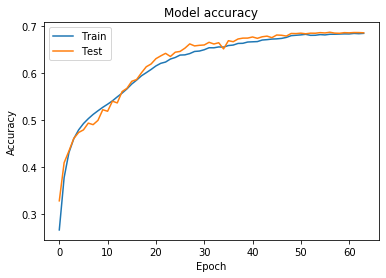

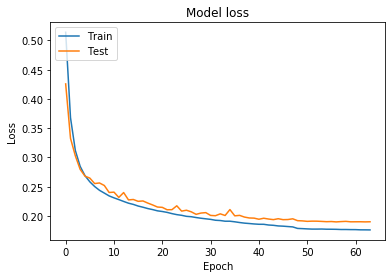

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()